### Further clean SPEND & PAYMENT variables (round to 2 decimals / integerize / ...)

In [1]:
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import random
import sys
import time
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
from pandarallel import pandarallel

In [2]:
from pathlib import Path
rootpath = Path.cwd().parent
sys.path.append(os.path.join(rootpath))

In [3]:
from utils.constants import *
from utils.eda_helpers import (
    plot_missing_proportion_barchart, get_cols, plot_scatterplot, plot_target_check, 
    plot_int_feature_distribution, plot_train_test_distribution, check_overlap_missing,
    insert_row_number, plot_sampled_time_series
)
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, BINARY_COLUMNS,
    MEAN_FEATURES, MIN_FEATURES, MAX_FEATURES, LAST_FEATURES, NON_FEATURE_COLUMNS
)
from utils.preprocess_helpers import *

In [4]:
%load_ext autoreload
%autoreload

In [5]:
gc.collect()

36

In [6]:
START = time.time()

### Read Data

In [7]:
%%time
train = read_file(f"{RAW_TRAIN_PARQUET_PATH}/spend_payment.parquet")
test = read_file(f"{RAW_TEST_PARQUET_PATH}/spend_payment.parquet")

Shape of data: (5531451, 26)
Shape of data: (11363762, 26)
CPU times: user 4.22 s, sys: 5.15 s, total: 9.36 s
Wall time: 6.6 s


In [8]:
%%time
public_test, private_test = split_public_private(test)

Public size: 5719469, Private size: 5644293
CPU times: user 2.55 s, sys: 758 ms, total: 3.31 s
Wall time: 4.4 s


In [9]:
del test

In [10]:
%%time
labels = pd.read_csv(f"{RAW_DATA_PATH}/train_labels.csv")
if "target" not in train.columns:
    train = train.merge(labels, on="customer_ID", how="left")

CPU times: user 775 ms, sys: 323 ms, total: 1.1 s
Wall time: 1.1 s


In [11]:
train.shape, public_test.shape, private_test.shape

((5531451, 27), (5719469, 26), (5644293, 26))

In [12]:
print(sorted(get_cols(train, ["P_", "S_"])))

['P_2', 'P_3', 'P_4', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_17', 'S_18', 'S_19', 'S_2', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9']


In [13]:
train["target"].mean()

0.24909720794778803

In [14]:
df_list = [train, public_test, private_test]

### P_2 (Done)

In [15]:
# plot_target_check(train, "P_2", q=50, use_raw_bin=True)

In [16]:
%%time
df_list = round_dfs(df_list, col="P_2", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 272 ms, sys: 1 s, total: 1.27 s
Wall time: 2.16 s


In [17]:
# plot_target_check(train, "P_2", q=50, use_raw_bin=True, nunique_thr=150, strfy_x=True, figsize=(25, 10))

In [18]:
# plot_train_test_distribution(df_list, "P_2", nunique_thr=150, figsize=(24, 9))

**Train Test Skew: Moderate**

### P_3

In [19]:
# plot_target_check(train, "P_3", q=50, use_raw_bin=True)

In [20]:
%%time
df_list = round_dfs(df_list, col="P_3", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 257 ms, sys: 797 ms, total: 1.05 s
Wall time: 1.98 s


301492 null count, 0.055 null proportion
0.4439 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


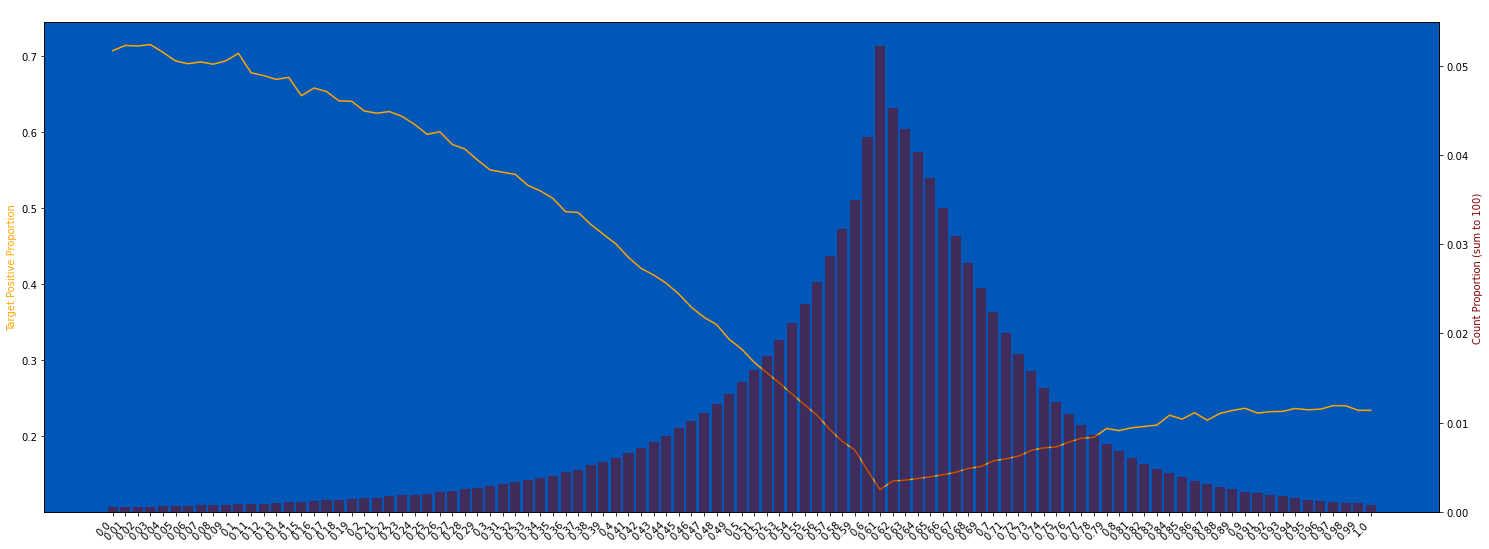

In [21]:
plot_target_check(train, "P_3", q=50, use_raw_bin=True, nunique_thr=340, strfy_x=True, figsize=(25, 10))

**ToDo:**
- Try come out with a feature with monotone relationship and see

In [22]:
# plot_train_test_distribution(df_list, "P_3", nunique_thr=340, figsize=(24, 10))

### P_4

In [23]:
# plot_target_check(train, "P_4", q=50, use_raw_bin=True)

In [24]:
%%time
df_list = round_dfs(df_list, col="P_4", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 232 ms, sys: 817 ms, total: 1.05 s
Wall time: 1.97 s


In [25]:
# plot_target_check(train, "P_4", q=50, use_raw_bin=True, strfy_x=True)

**Comments:**
- P_4 in (0, 0.01) should be NaN, because it has different default trend + extremely low values (outlier)
- Also, original P_4 has no missing values

In [26]:
%%time
df_list = fill_nans(df_list, col="P_4", tuple_of_values=(0, 0.01), add_new_col=False)

CPU times: user 100 ms, sys: 81 ms, total: 181 ms
Wall time: 181 ms


4732506 null count, 0.856 null proportion
0.2073 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


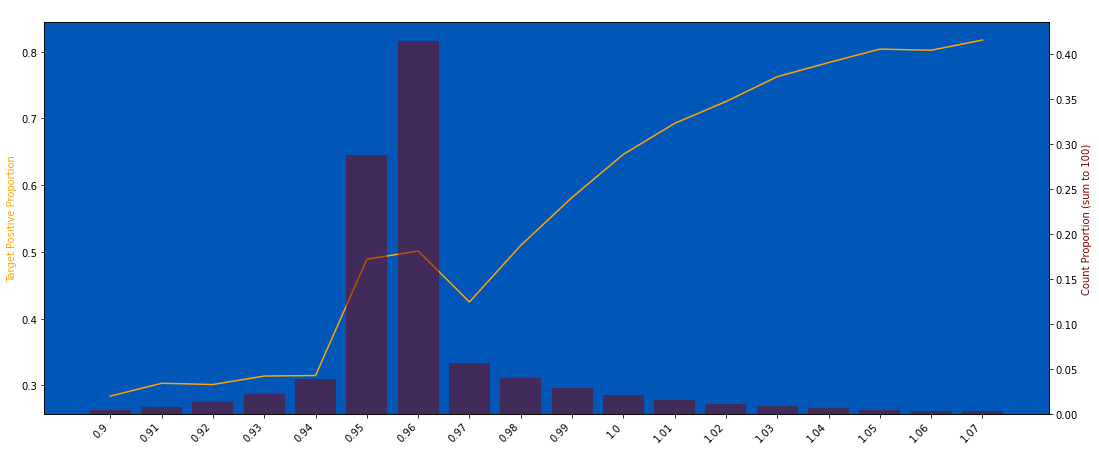

In [27]:
plot_target_check(train, "P_4", q=50, use_raw_bin=True, strfy_x=True)

**ToDo:**
- Identify the subset of P_4 in (0.95, 0.96) to fill with other values, to fix
  - The spike in default trend & distribution bell curve

Bottom 1% and Top 1% are dropped from this chart


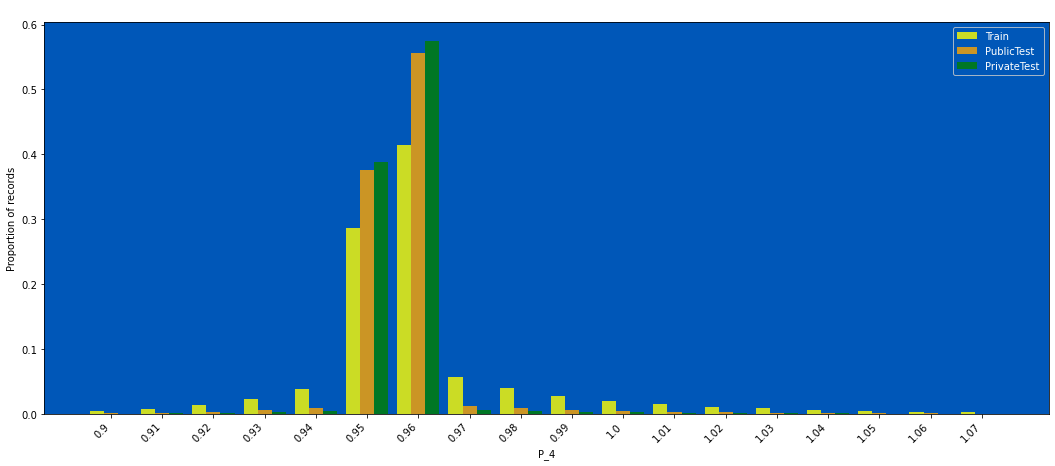

In [28]:
plot_train_test_distribution(df_list, "P_4")

**Train Test Skew: Heavy**

### S_3

In [29]:
# plot_target_check(train, "S_3", q=50, use_raw_bin=True)

In [30]:
%%time
df_list = round_dfs(df_list, col="S_3", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 264 ms, sys: 785 ms, total: 1.05 s
Wall time: 2 s


1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


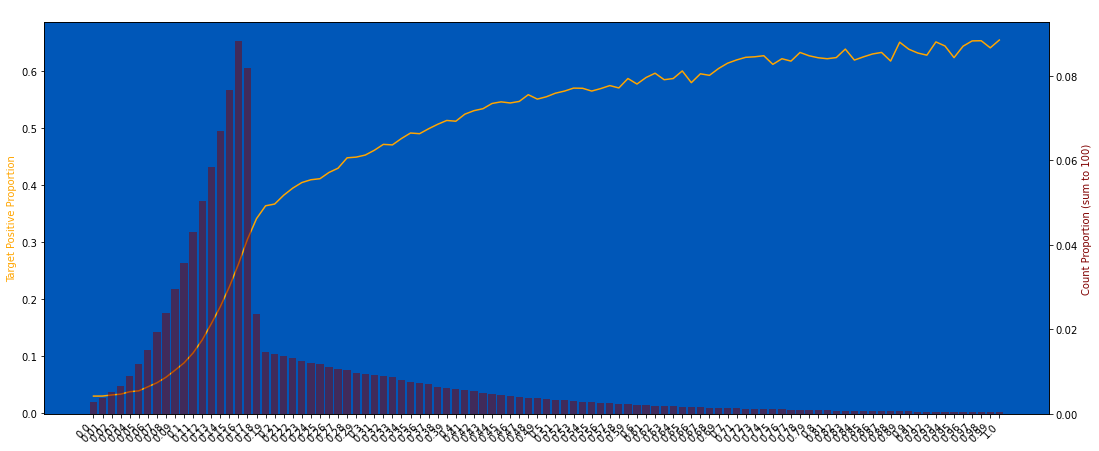

In [31]:
plot_target_check(train, "S_3", q=50, use_raw_bin=True, nunique_thr=700, strfy_x=True)

**ToDo:**
- Apply manual stacking / binning on right tail

In [32]:
# plot_train_test_distribution(df_list, "S_3", nunique_thr=500)

### S_5

In [33]:
# plot_target_check(train, "S_5", q=50, use_raw_bin=True)

In [34]:
%%time
df_list = round_dfs(df_list, col="S_5", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 245 ms, sys: 834 ms, total: 1.08 s
Wall time: 1.99 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


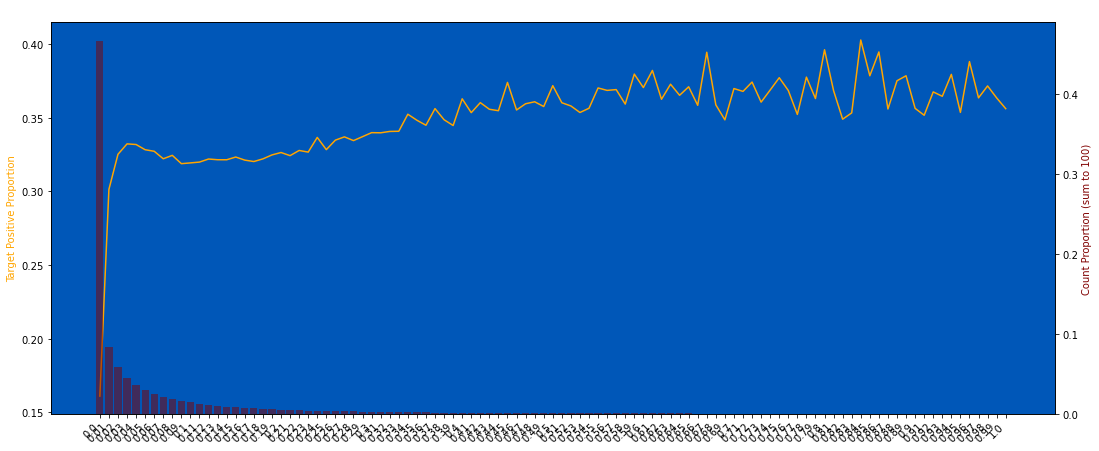

In [35]:
plot_target_check(train, "S_5", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

**ToDo:**
- Should apply manual stack / binning on the right tail

In [36]:
# plot_train_test_distribution(df_list, "S_5", nunique_thr=5000)

### S_6 (Done)

In [37]:
# plot_target_check(train, "S_6", q=50, use_raw_bin=True, nunique_thr=5, strfy_x=True)

In [38]:
%%time
df_list = round_dfs(df_list, col="S_6", decimals=1, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 238 ms, sys: 846 ms, total: 1.08 s
Wall time: 1.99 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


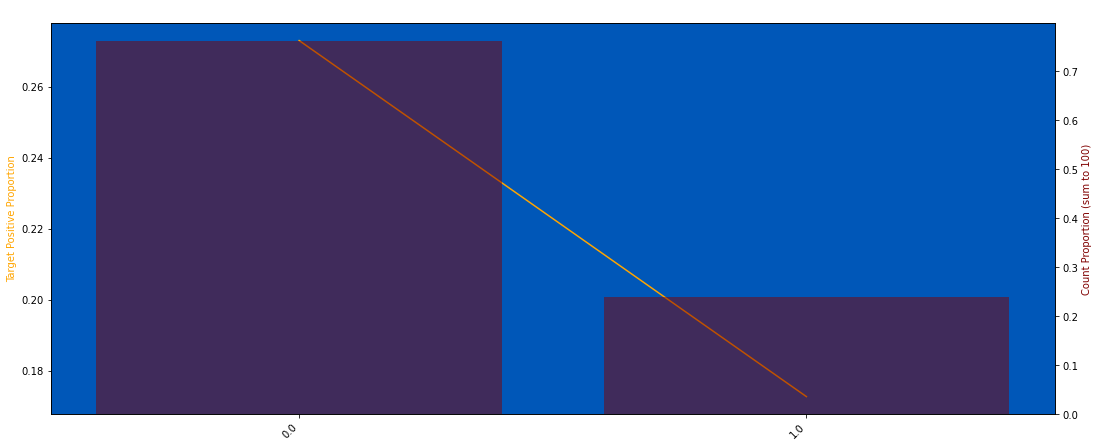

In [39]:
plot_target_check(train, "S_6", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [40]:
for df in df_list:
    df["S_6"] = integerize(df["S_6"])

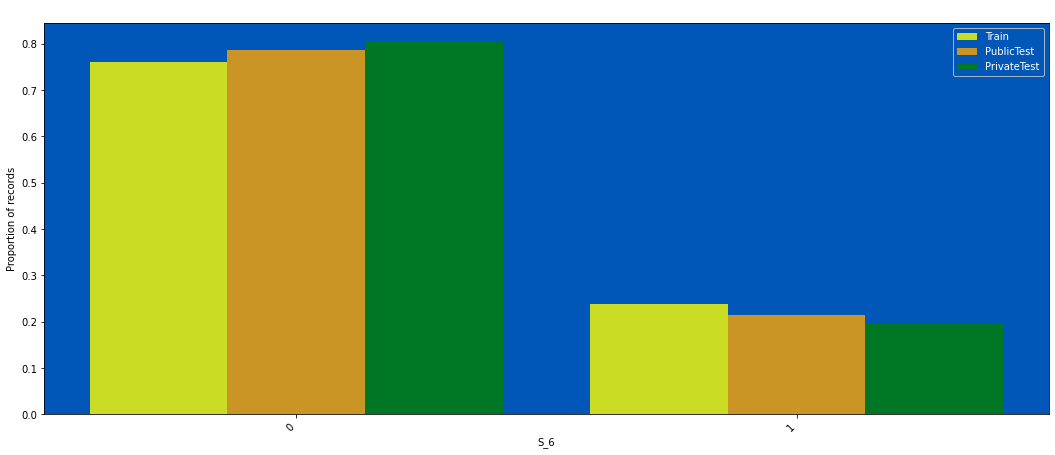

In [41]:
plot_train_test_distribution(df_list, "S_6", nunique_thr=50)

### S_7

In [42]:
# plot_target_check(train, "S_7", q=50, use_raw_bin=True)

In [43]:
%%time
df_list = round_dfs(df_list, col="S_7", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 248 ms, sys: 871 ms, total: 1.12 s
Wall time: 2.06 s


1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


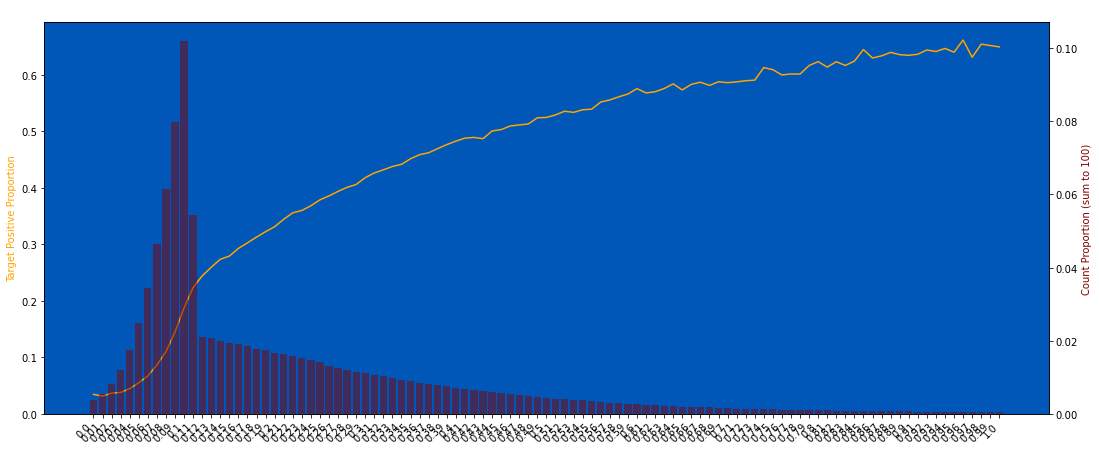

In [44]:
plot_target_check(train, "S_7", q=50, use_raw_bin=True, nunique_thr=360, strfy_x=True)

**ToDo:**
- Apply manual stacking / binning on right tail

In [45]:
# plot_train_test_distribution(df_list, "S_7", nunique_thr=5000)

### S_8

In [46]:
# plot_target_check(train, "S_8", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

In [47]:
%%time
df_list = round_dfs(df_list, col="S_8", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 214 ms, sys: 851 ms, total: 1.06 s
Wall time: 1.98 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


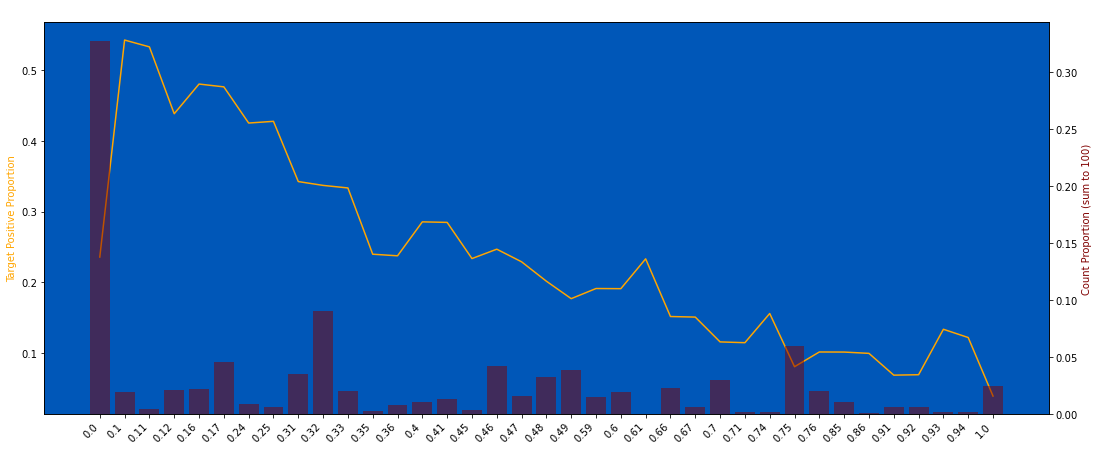

In [48]:
plot_target_check(train, "S_8", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

**Comments**
- S_8 in (0, 0.01) is likely to be NaN, because it violates the default rate downward trend & its average default rate is around 25%
- Also, original S_8 has no null values

In [49]:
%%time
df_list = fill_nans(df_list, col="S_8", tuple_of_values=(0), add_new_col=False)

CPU times: user 267 ms, sys: 1.16 s, total: 1.43 s
Wall time: 273 ms


1808480 null count, 0.327 null proportion
0.2354 of the targets have label = 1


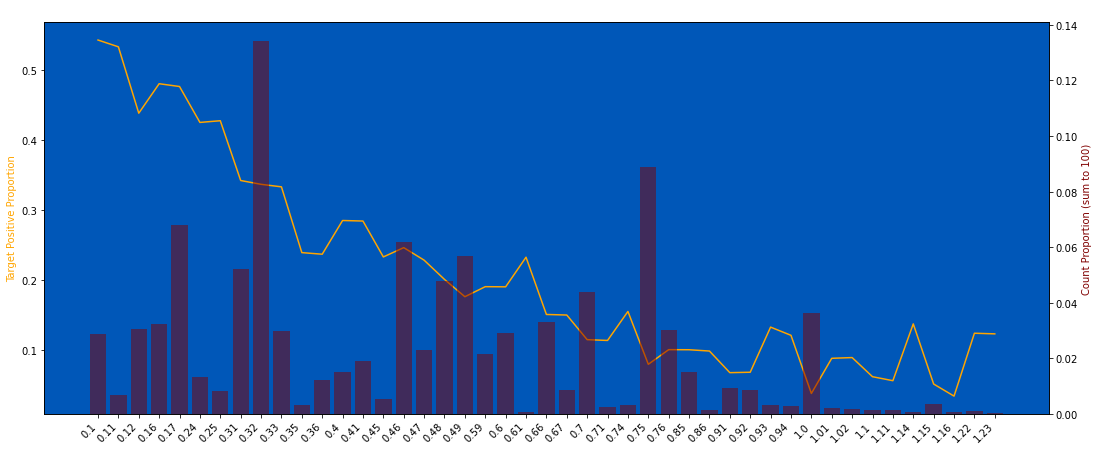

In [50]:
plot_target_check(train, "S_8", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

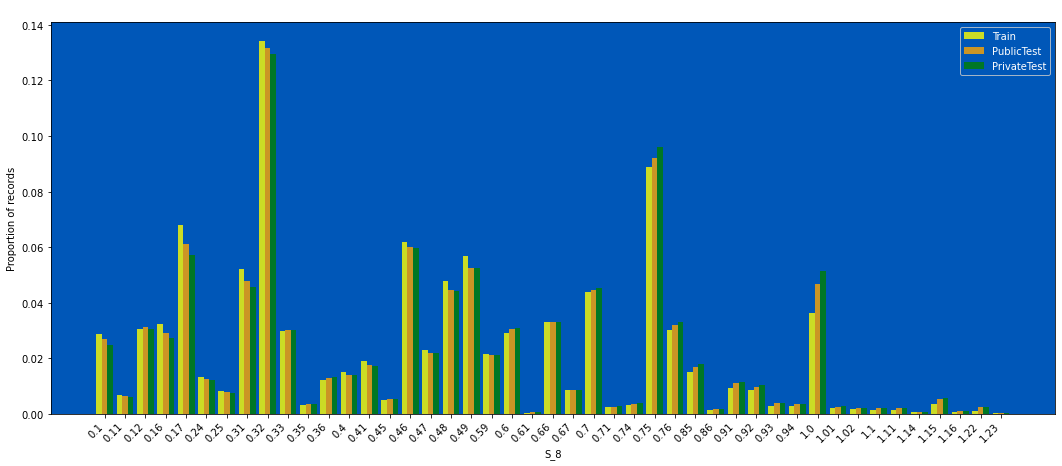

In [51]:
plot_train_test_distribution(df_list, "S_8", nunique_thr=500, without_drop_tail=True)

### S_9

In [52]:
# plot_target_check(train, "S_9", q=50, use_raw_bin=True)

In [53]:
%%time
df_list = round_dfs(df_list, col="S_9", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 240 ms, sys: 926 ms, total: 1.17 s
Wall time: 2.17 s


2933643 null count, 0.530 null proportion
0.2719 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


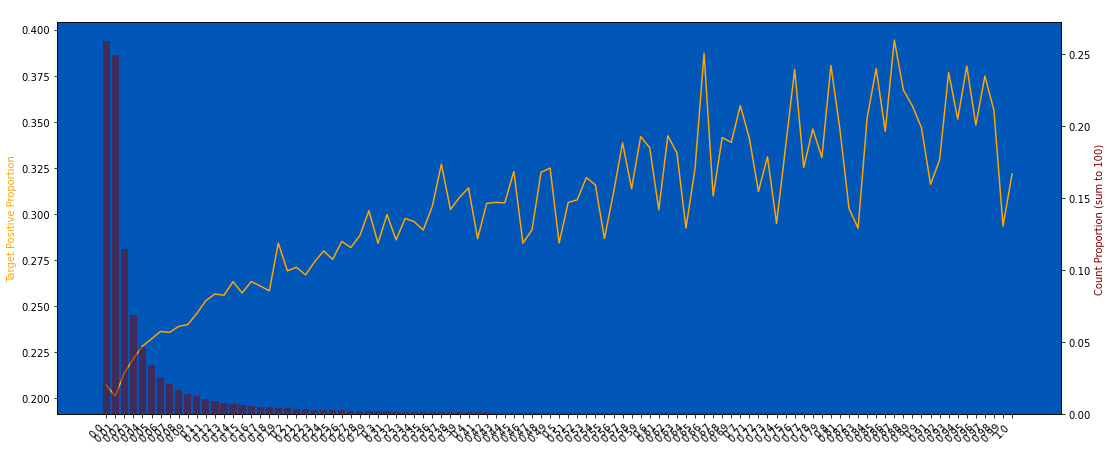

In [54]:
plot_target_check(train, "S_9", q=50, use_raw_bin=True, nunique_thr=300, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


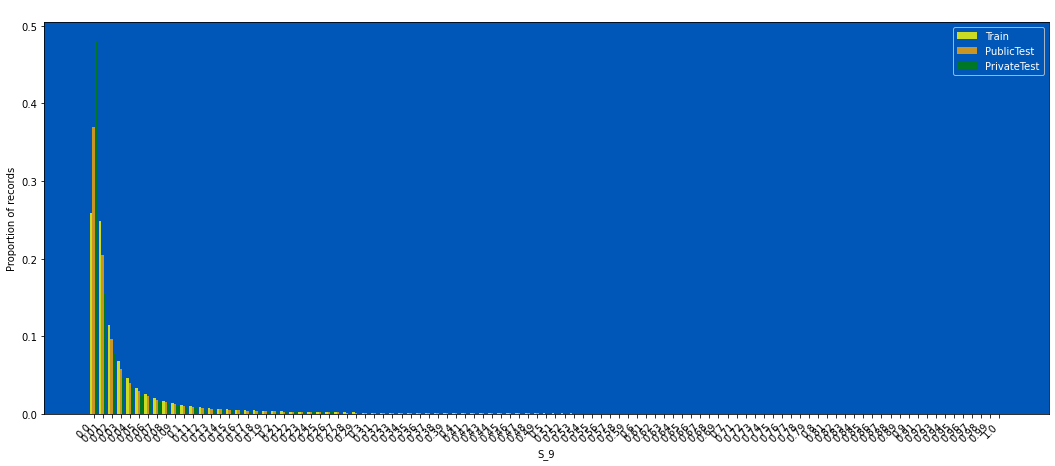

In [55]:
plot_train_test_distribution(df_list, "S_9", nunique_thr=300)

**Train Test Skew: Moderate**

### S_11

In [56]:
# plot_target_check(train, "S_11", q=50, use_raw_bin=True)

In [57]:
df_list = round_dfs(df_list, col="S_11", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


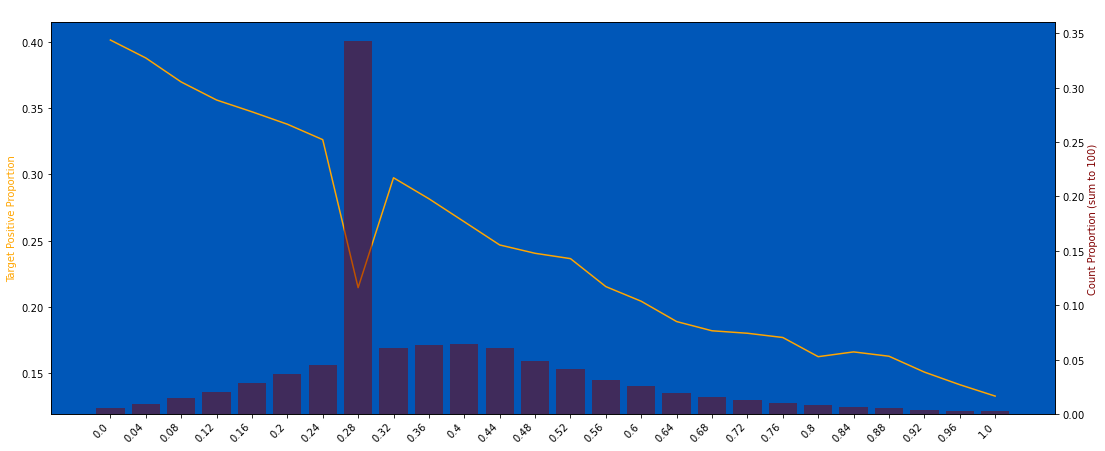

In [58]:
plot_target_check(train, "S_11", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [59]:
for df in df_list:
    df["S_11_"] = (df["S_11"] / 0.04).round(0)

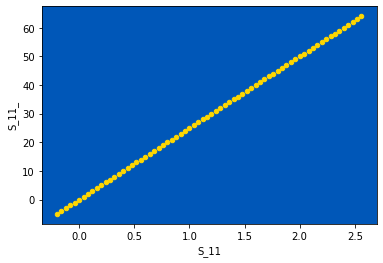

In [60]:
check_binning(train, "S_11", end=70)

In [61]:
for df in df_list:
    df["S_11"] = (df["S_11"] / 0.04).round(0)

In [62]:
s11_min_max_df = train.groupby("customer_ID").agg(
    s11_max=("S_11", "max"), 
    s11_min=("S_11", "min")
)

In [63]:
t = s11_min_max_df.loc[s11_min_max_df["s11_max"] == s11_min_max_df["s11_min"]]
sus_cid_list = t.loc[t["s11_max"] == 7].index.tolist()

In [64]:
train.loc[train["customer_ID"].isin(sus_cid_list), "S_11"] = np.nan

711032 null count, 0.129 null proportion
0.0527 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


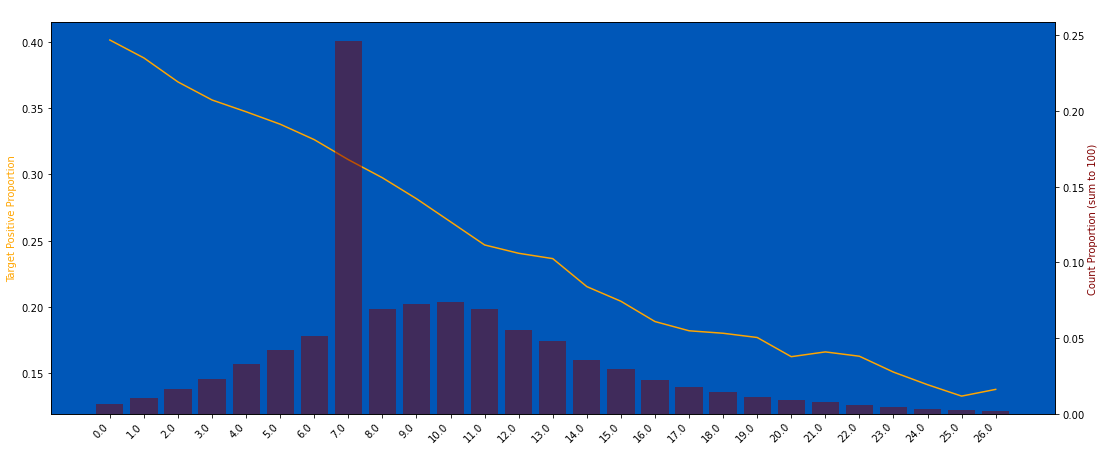

In [65]:
plot_target_check(train, "S_11", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


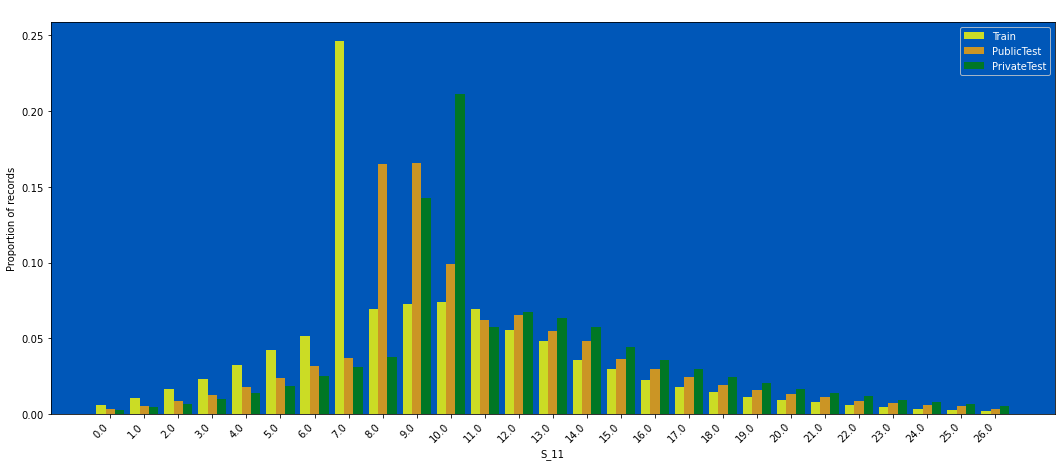

In [66]:
plot_train_test_distribution(df_list, "S_11", nunique_thr=50000)

**Train Test Skew: Heavy**

**ToDo:**
- Identify subset of 7 - 10 to be replace by other values to fix the train test skew & make the bell curve smoother
- If not able to do that, drop this column S_11

### S_12

In [67]:
# plot_target_check(train, "S_12", q=50, use_raw_bin=True)

In [68]:
%%time
df_list = round_dfs(df_list, col="S_12", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 239 ms, sys: 873 ms, total: 1.11 s
Wall time: 2.01 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


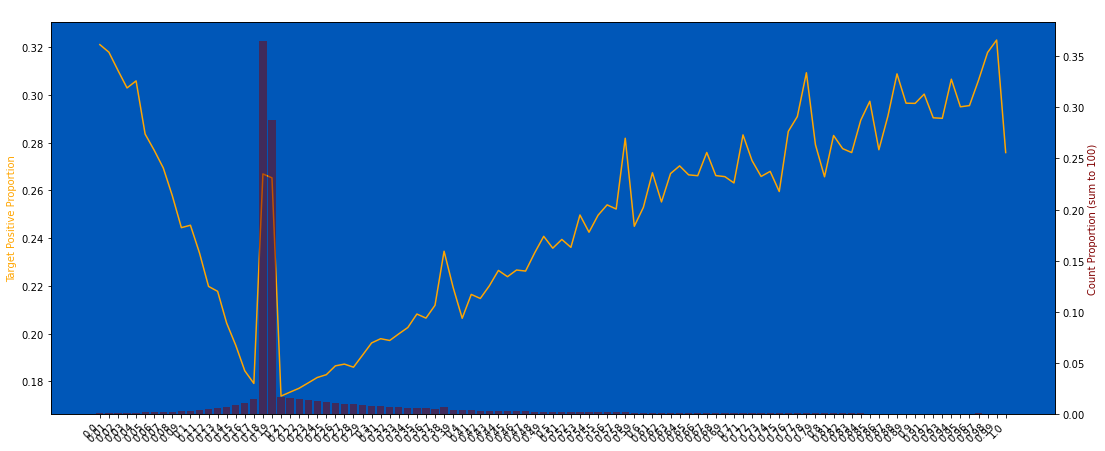

In [69]:
plot_target_check(train, "S_12", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

#### ToDo:
- Replace some of the 0.18 & 0.19 with NaN, need to find the appropriate way to filter the subset to be replace

Bottom 1% and Top 1% are dropped from this chart


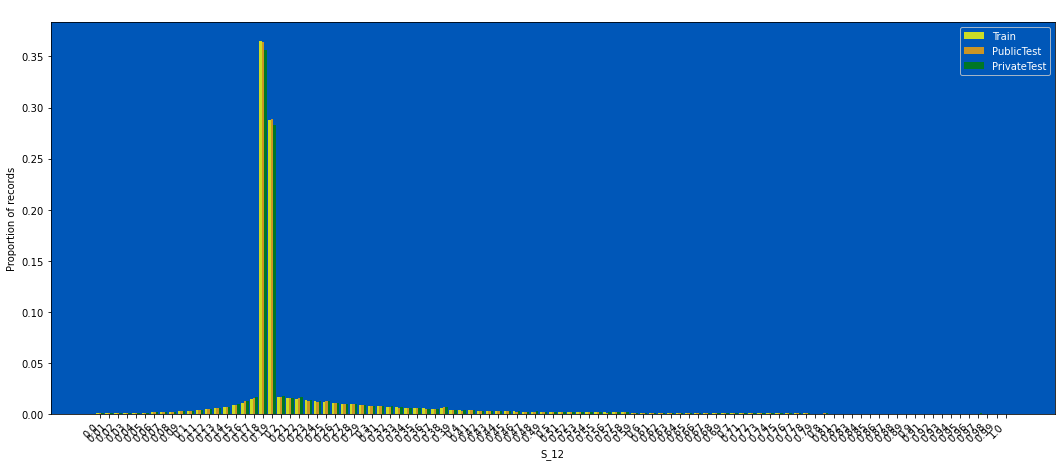

In [70]:
plot_train_test_distribution(df_list, "S_12", nunique_thr=50000)

**Train Test Skew: Mild**

### S_13

In [71]:
# plot_target_check(train, "S_13", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True)

In [72]:
%%time
df_list = round_dfs(df_list, col="S_13", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 223 ms, sys: 888 ms, total: 1.11 s
Wall time: 2.03 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


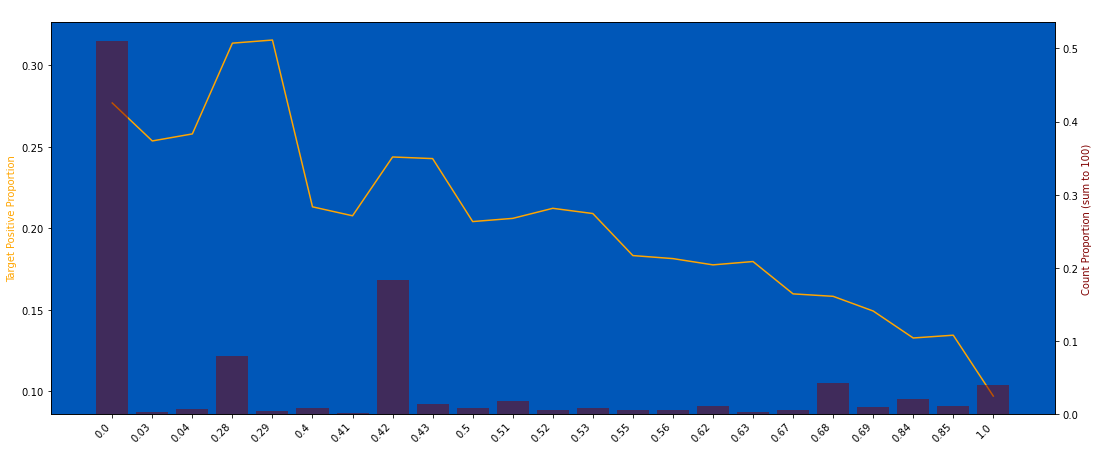

In [73]:
plot_target_check(train, "S_13", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [74]:
mapping_dict = {0.03: 1, 0.04: 1, 0.28: 2, 0.29: 2, 0.4 : 3, 0.41: 3, 0.42: 4, 0.43: 4, 
                0.5 : 5, 0.51: 5, 0.52: 6, 0.53: 6, 0.55: 7, 0.56: 7, 0.62: 8, 0.63: 8, 
                0.68: 9, 0.69: 10, 0.84: 11, 0.85: 11, 1: 12}

In [75]:
for df in df_list:
    df["S_13_"] = df["S_13"].map(mapping_dict)

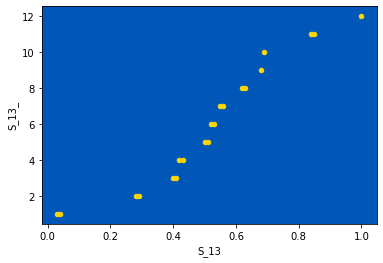

In [76]:
check_binning(train, "S_13", end=200)

In [77]:
for df in df_list:
    df["S_13"] = df["S_13"].map(mapping_dict)

2849419 null count, 0.515 null proportion
0.2758 of the targets have label = 1


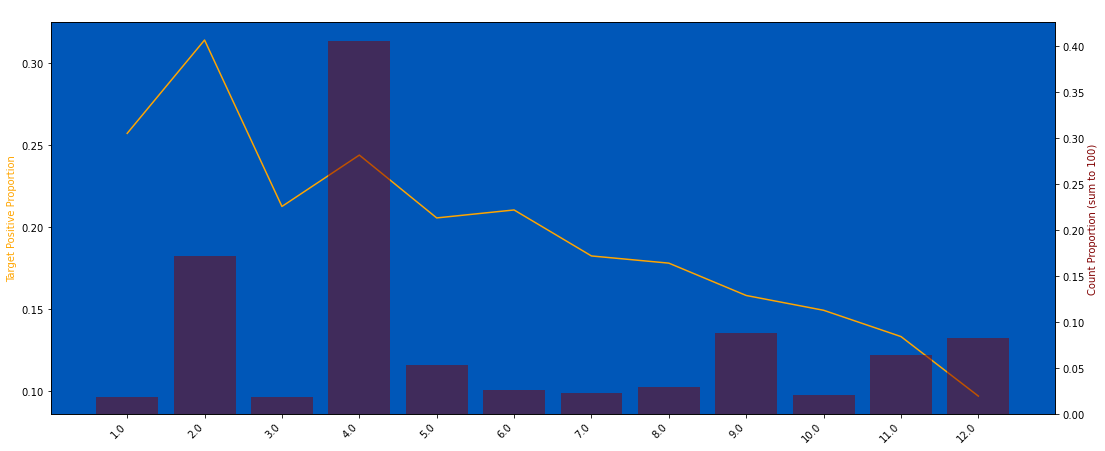

In [78]:
plot_target_check(train, "S_13", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

Bottom 1% and Top 1% are dropped from this chart


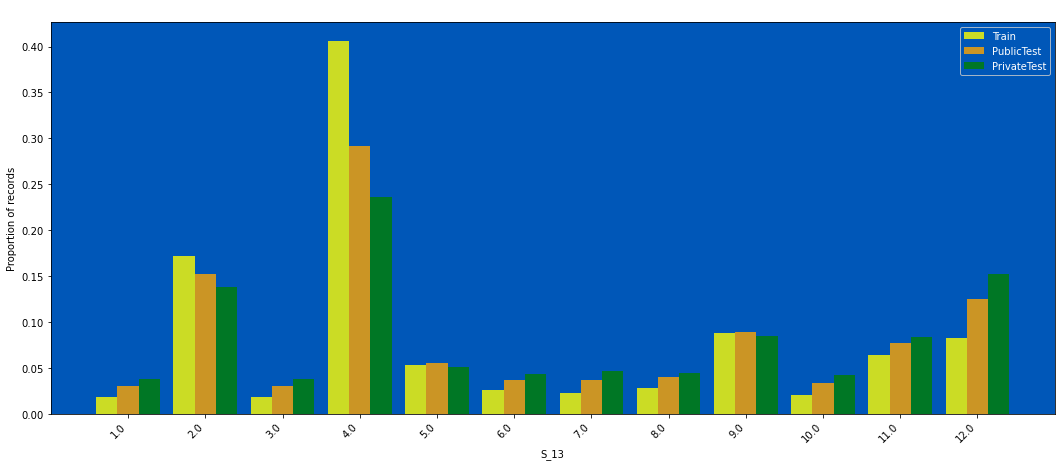

In [79]:
plot_train_test_distribution(df_list, "S_13", nunique_thr=50000)

**Train Test Skew: Heavy**

### S_15

In [80]:
# plot_target_check(train, "S_15", q=50, use_raw_bin=True)

In [81]:
%%time
df_list = round_dfs(df_list, col="S_15", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 237 ms, sys: 872 ms, total: 1.11 s
Wall time: 2.01 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


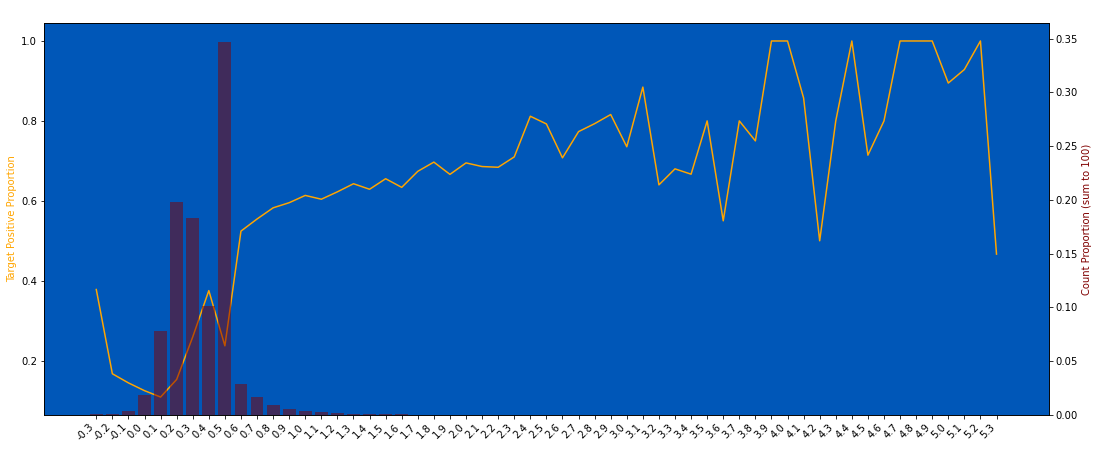

In [82]:
plot_target_check(train, "S_15", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

**Comments:**
- Some of the 0.5 - 0.51 are suspiciously null value, reason => violate bell curve & spike in default trend (lower default rate)

In [83]:
# for df in df_list:
#     df["S_15_"] = df["S_15"].copy()
#     df.loc[df["S_15"].between(0.5, 0.51), "S_15_"] = np.nan

In [84]:
# for col in train.columns[2:]:
#     if col == "temp":
#         continue
#     corrcoef = train[["S_15_", col]].dropna().corr().iloc[0, 1]
#     if abs(corrcoef) >= 0.3:
#         print(col, corrcoef)

**Comments:**
- S_8 has the highest (absolute) correlation with S_15, use this information to cross validate the 0.5 - 0.51

In [85]:
train["S_8"].describe()

count   3,722,971.0000
mean            0.4793
std             0.2477
min             0.1000
25%             0.3200
50%             0.4600
75%             0.7000
max             1.2300
Name: S_8, dtype: float64

In [86]:
train.loc[train["S_8"].isnull(), "S_15"].describe()

count   1,808,480.0000
mean            0.5212
std             0.1140
min             0.5000
25%             0.5000
50%             0.5000
75%             0.5000
max             5.3000
Name: S_15, dtype: float64

In [87]:
np.percentile(train.loc[train["S_8"].isnull(), "S_15"].dropna(), 0)

0.5

In [88]:
np.percentile(train.loc[train["S_8"].isnull(), "S_15"].dropna(), 95)

0.6

**Comments:**
- When S_8 is null, S_15 is likely to be 0.5 (about 93% of them)
- Replace those S_15 (0.5 - 0.51) with NaN

In [89]:
for df in df_list:
    df.loc[df["S_8"].isnull(), "S_15"] = np.nan

1808480 null count, 0.327 null proportion
0.2354 of the targets have label = 1


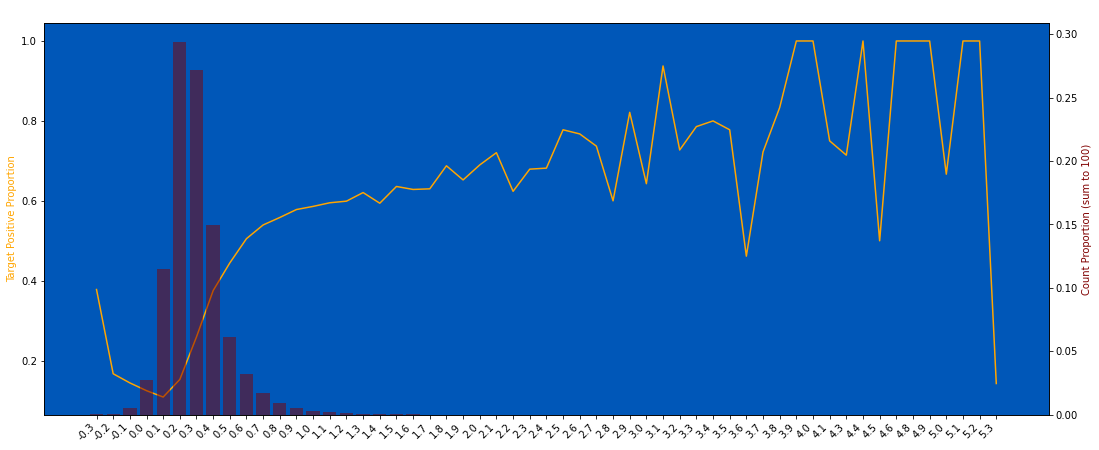

In [90]:
plot_target_check(train, "S_15", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

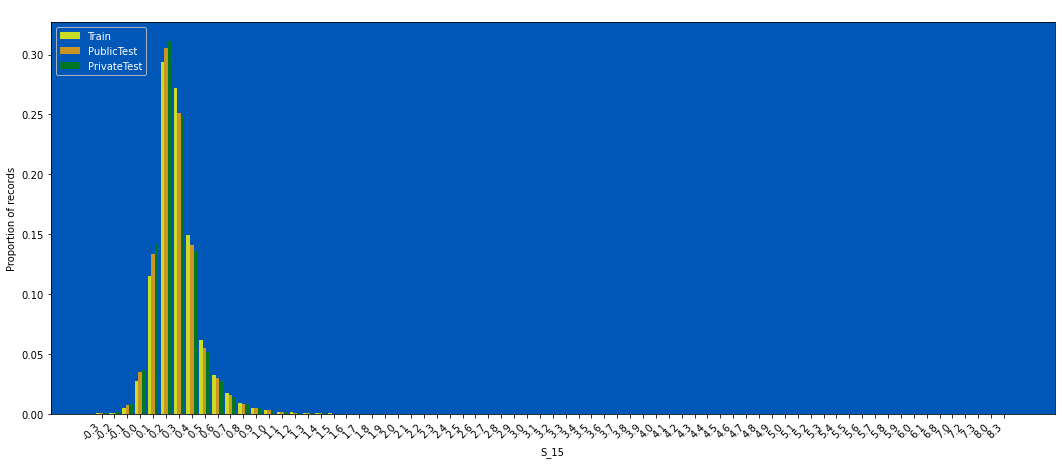

In [91]:
plot_train_test_distribution(df_list, "S_15", nunique_thr=500, without_drop_tail=True)

### S_16

In [92]:
# plot_target_check(train, "S_16", q=50, use_raw_bin=True)

In [93]:
%%time
df_list = round_dfs(df_list, col="S_16", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 230 ms, sys: 894 ms, total: 1.12 s
Wall time: 2.01 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


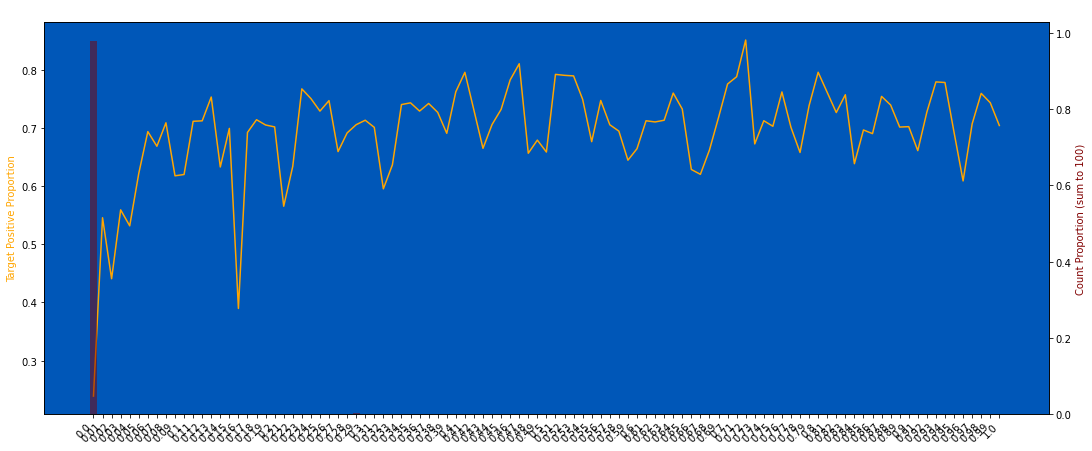

In [94]:
plot_target_check(train, "S_16", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


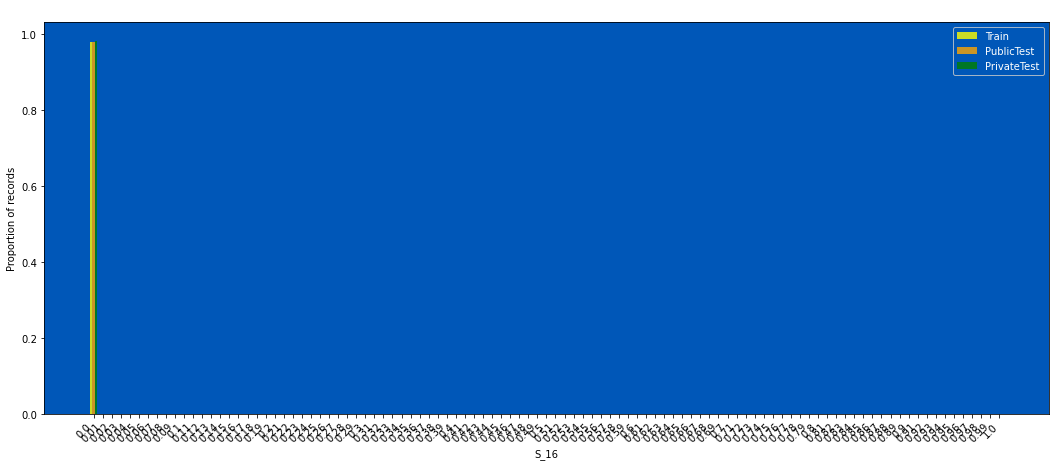

In [95]:
plot_train_test_distribution(df_list, "S_16", nunique_thr=5000)

**ToDo:**
- Replace some zeros as NaN

### S_17

In [96]:
# plot_target_check(train, "S_17", q=50, use_raw_bin=True)

In [97]:
%%time
df_list = round_dfs(df_list, col="S_17", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 219 ms, sys: 910 ms, total: 1.13 s
Wall time: 2.04 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


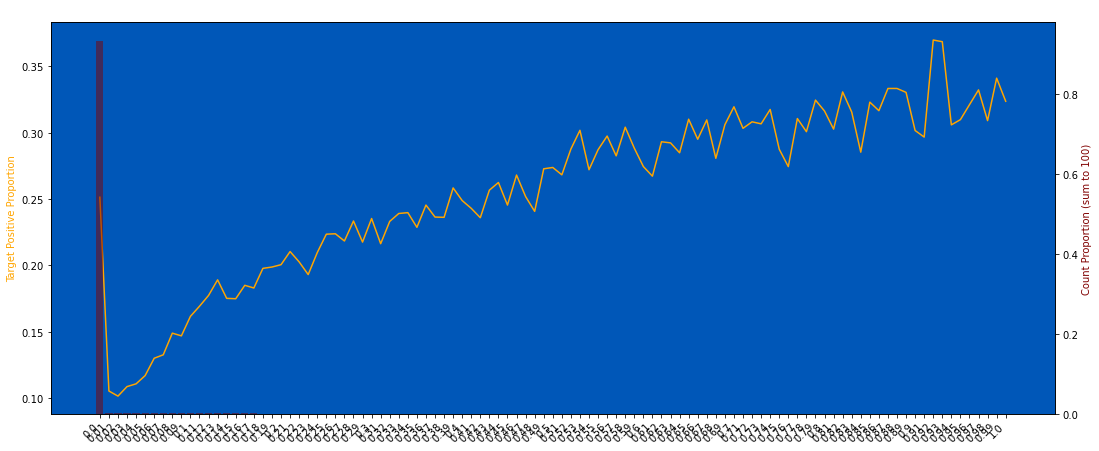

In [98]:
plot_target_check(train, "S_17", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [99]:
df_list = fill_nans(df_list, col="S_17", method="point", tuple_of_values=(0), add_new_col=False)

5155271 null count, 0.932 null proportion
0.2513 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


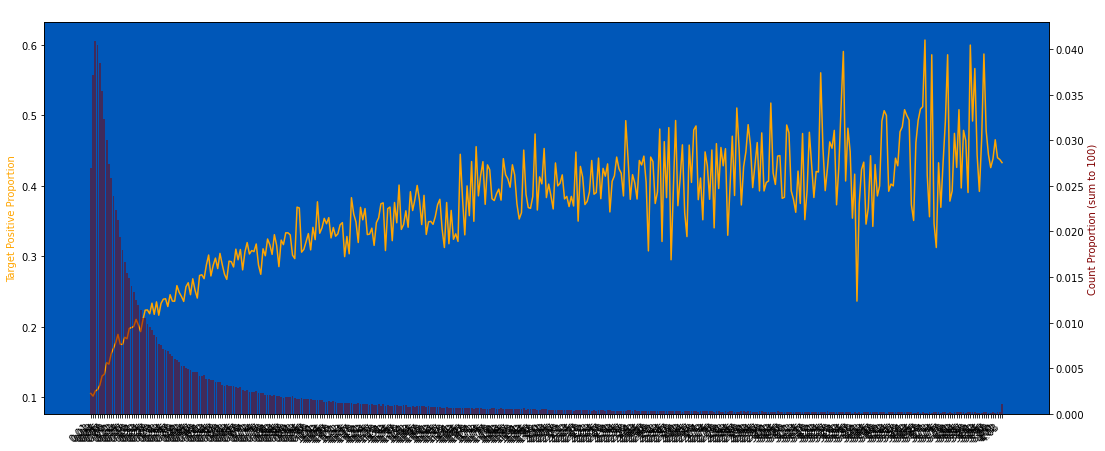

In [100]:
plot_target_check(train, "S_17", q=50, use_raw_bin=True, nunique_thr=1500, strfy_x=True)

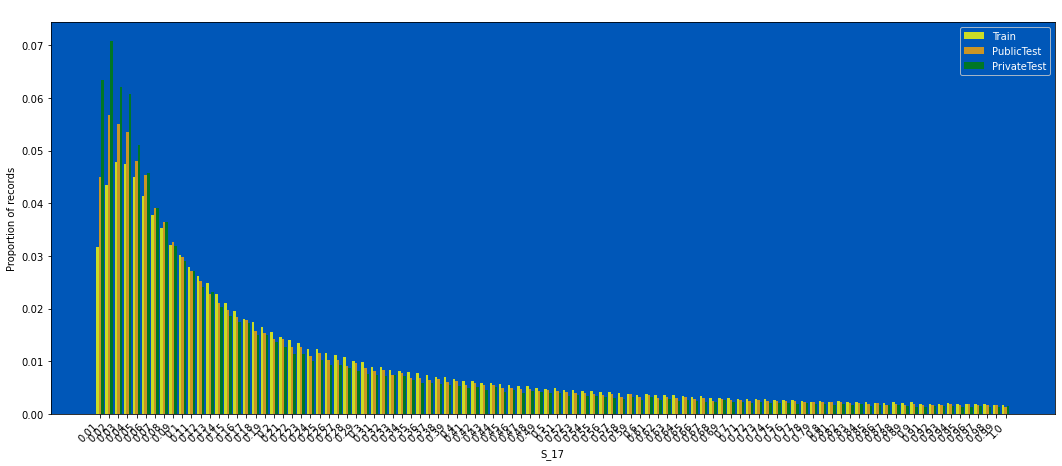

In [101]:
plot_train_test_distribution(
    [
        train.loc[train["S_17"] <= 1], 
        public_test.loc[public_test["S_17"] <= 1],
        private_test.loc[private_test["S_17"] <= 1]
    ],
    "S_17", 
    nunique_thr=15000,
    without_drop_tail=True
)

**Train Test Skew: Heavy**

### S_18 (Done)

In [102]:
# plot_target_check(train, "S_18", q=50, use_raw_bin=True)

In [103]:
%%time
df_list = round_dfs(df_list, col="S_18", decimals=1, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 227 ms, sys: 966 ms, total: 1.19 s
Wall time: 2.1 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


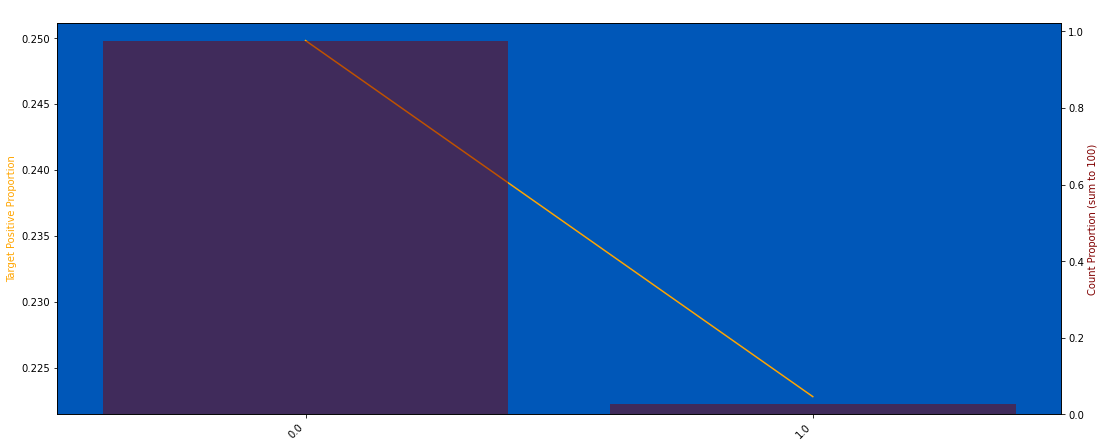

In [104]:
plot_target_check(train, "S_18", q=50, use_raw_bin=True, nunique_thr=5, strfy_x=True, without_drop_tail=True)

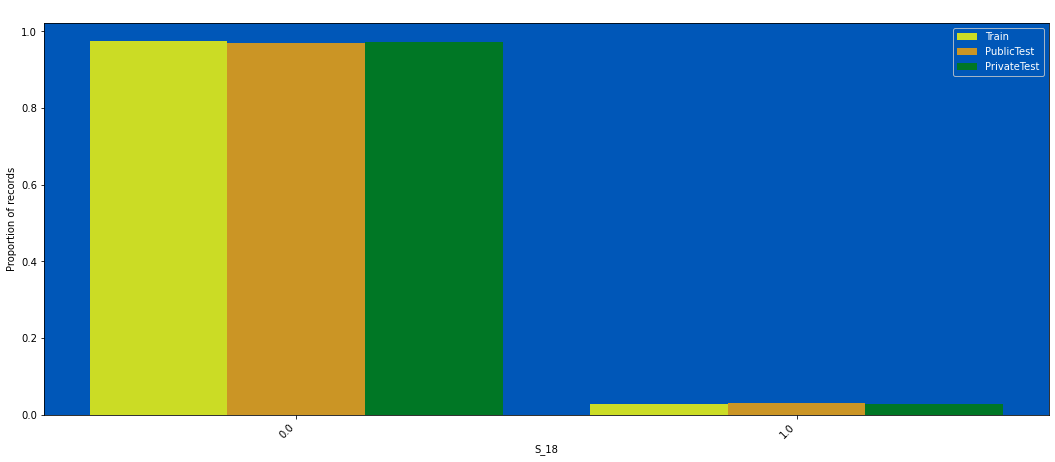

In [105]:
plot_train_test_distribution(df_list, "S_18", nunique_thr=150, without_drop_tail=True)

### S_19 (Done)

In [106]:
# plot_target_check(train, "S_19", q=50, use_raw_bin=True)

In [107]:
%%time
df_list = round_dfs(df_list, col="S_19", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 290 ms, sys: 1.05 s, total: 1.34 s
Wall time: 2.23 s


In [108]:
for df in df_list:
    print(df["S_19"].mean())

2.7790176573923133e-05
2.6741993006693942e-05
2.6708393770487004e-05


In [109]:
%%time
for df in df_list:
    df = df.drop(columns=["S_19"], errors="ignore")

CPU times: user 671 ms, sys: 1.02 s, total: 1.69 s
Wall time: 1.68 s


### S_20 (Done)

In [110]:
# plot_target_check(train, "S_20", q=50, use_raw_bin=True, nunique_thr=200)

In [111]:
%%time
df_list = round_dfs(df_list, col="S_20", decimals=1, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 221 ms, sys: 1.02 s, total: 1.24 s
Wall time: 2.17 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


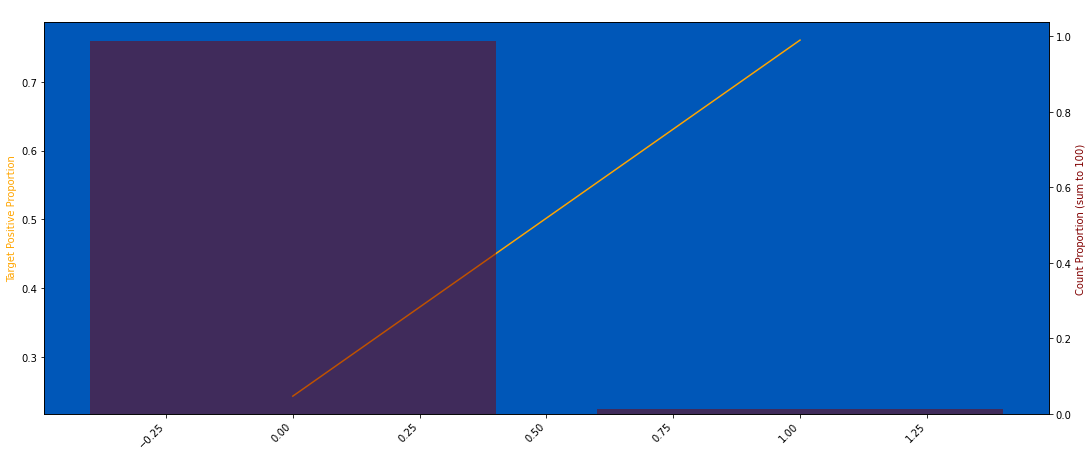

In [112]:
plot_target_check(train, "S_20", q=50, use_raw_bin=True, nunique_thr=2000, without_drop_tail=True)

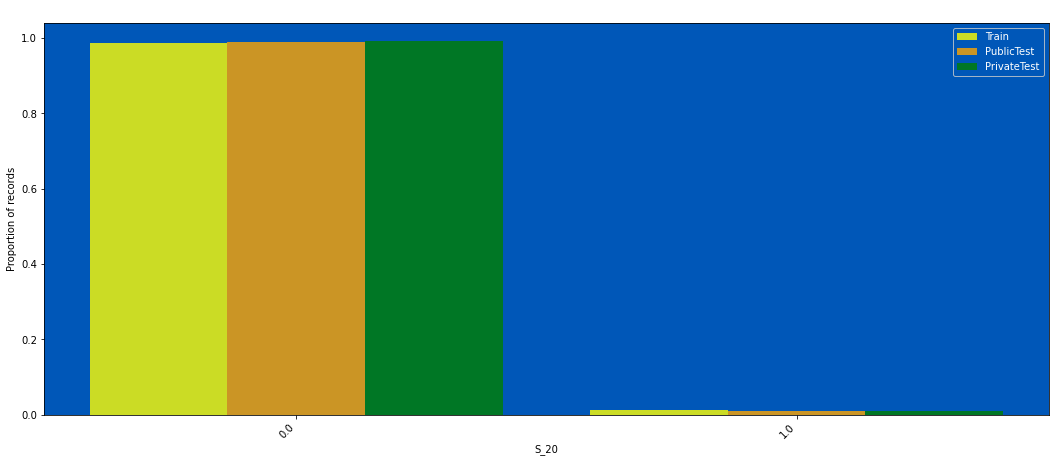

In [113]:
plot_train_test_distribution(df_list, "S_20", nunique_thr=50, without_drop_tail=True)

### S_22

In [114]:
# plot_target_check(train, "S_22", q=50, use_raw_bin=True)

In [115]:
%%time
df_list = round_dfs(df_list, col="S_22", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 298 ms, sys: 1.03 s, total: 1.33 s
Wall time: 2.24 s


19024 null count, 0.003 null proportion
0.1320 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


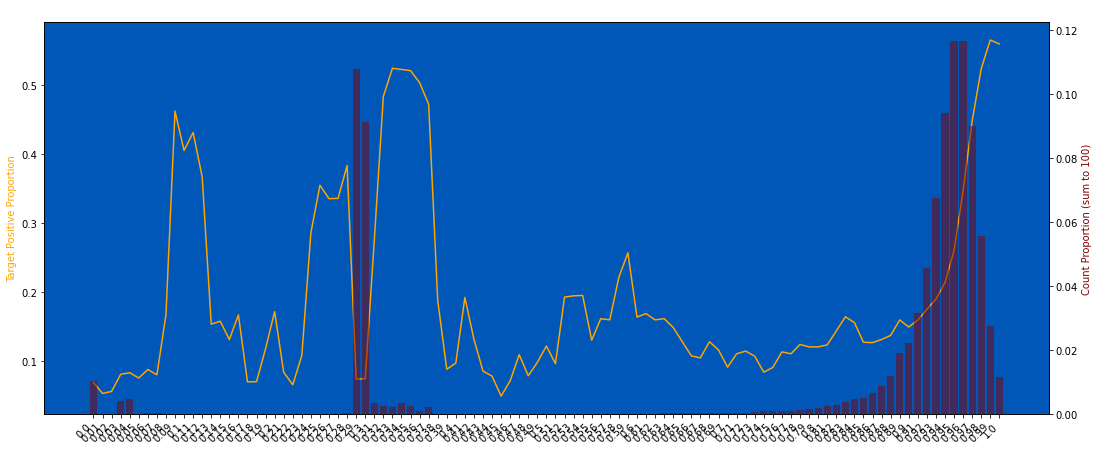

In [116]:
plot_target_check(train, "S_22", q=50, use_raw_bin=True, nunique_thr=777, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


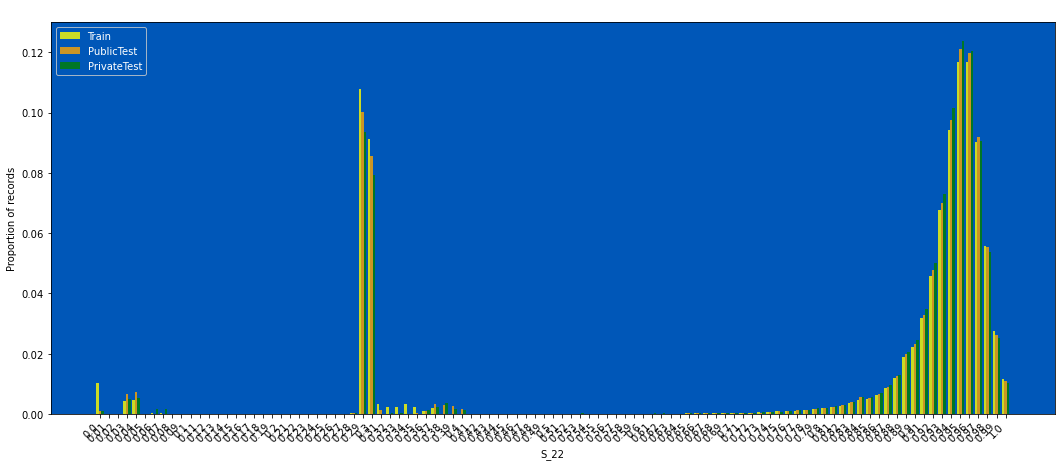

In [117]:
plot_train_test_distribution(df_list, "S_22", nunique_thr=777)

**Comments:**
- **Train Test Skew: Moderate**
- Relationship is ambigious

### S_23

In [118]:
# plot_target_check(train, "S_23", q=50, use_raw_bin=True)

In [119]:
%%time
df_list = round_dfs(df_list, col="S_23", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 288 ms, sys: 1.13 s, total: 1.42 s
Wall time: 2.35 s


445 null count, 0.000 null proportion
0.5236 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


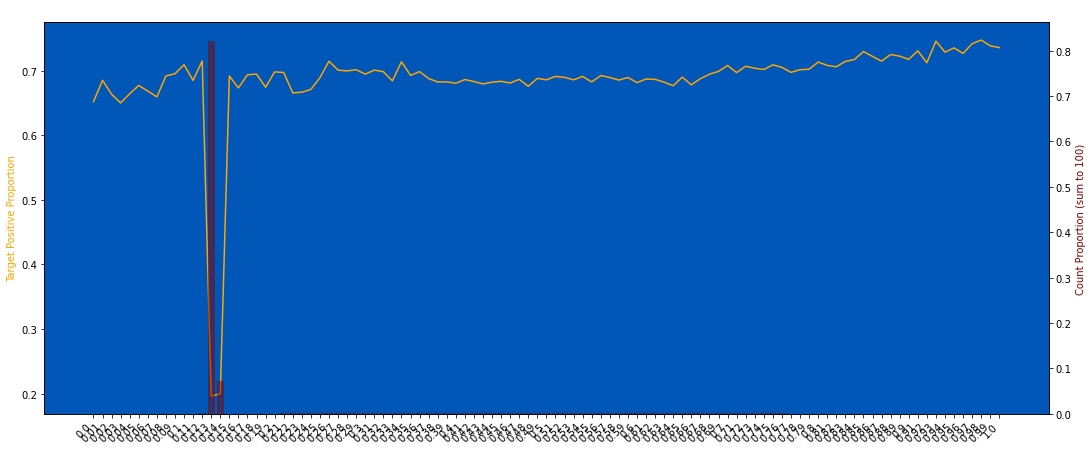

In [120]:
plot_target_check(train, "S_23", q=50, use_raw_bin=True, strfy_x=True, nunique_thr=1600)

**ToDo:**
- Identify the subset of 0.13 & 0.14 to be replace by NaN

Bottom 1% and Top 1% are dropped from this chart


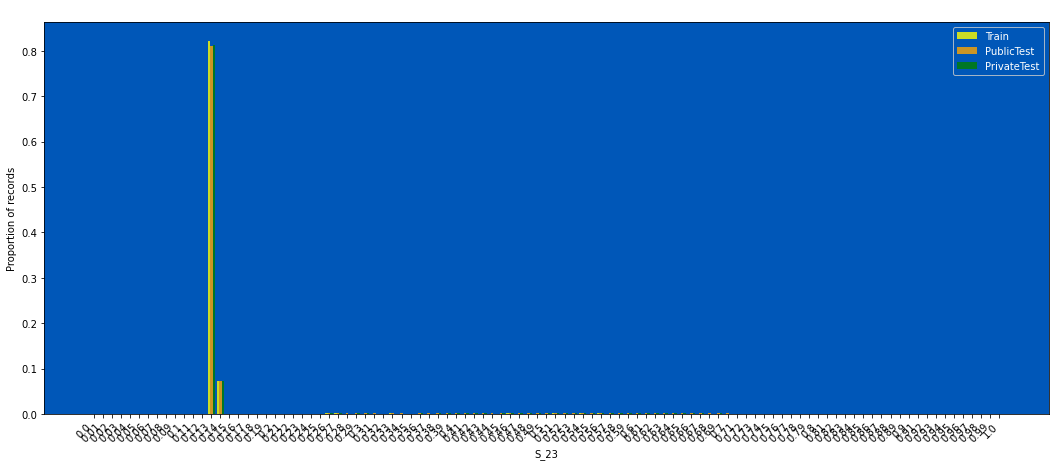

In [121]:
plot_train_test_distribution(df_list, "S_23", nunique_thr=1600)

### S_24

In [122]:
# plot_target_check(train, "S_24", q=50, use_raw_bin=True)

In [123]:
%%time
df_list = round_dfs(df_list, col="S_24", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 277 ms, sys: 1.03 s, total: 1.31 s
Wall time: 2.24 s


18593 null count, 0.003 null proportion
0.1317 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


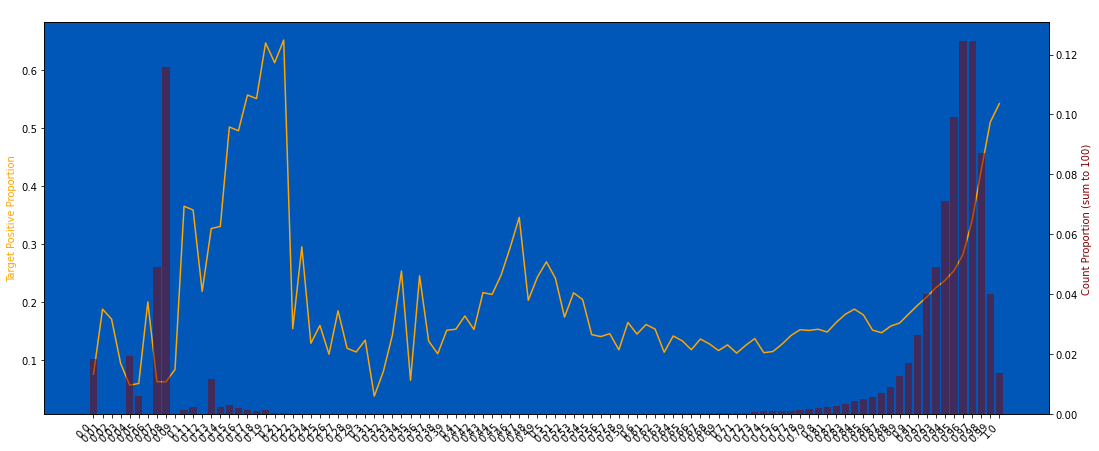

In [124]:
plot_target_check(train, "S_24", q=50, use_raw_bin=True, nunique_thr=650, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


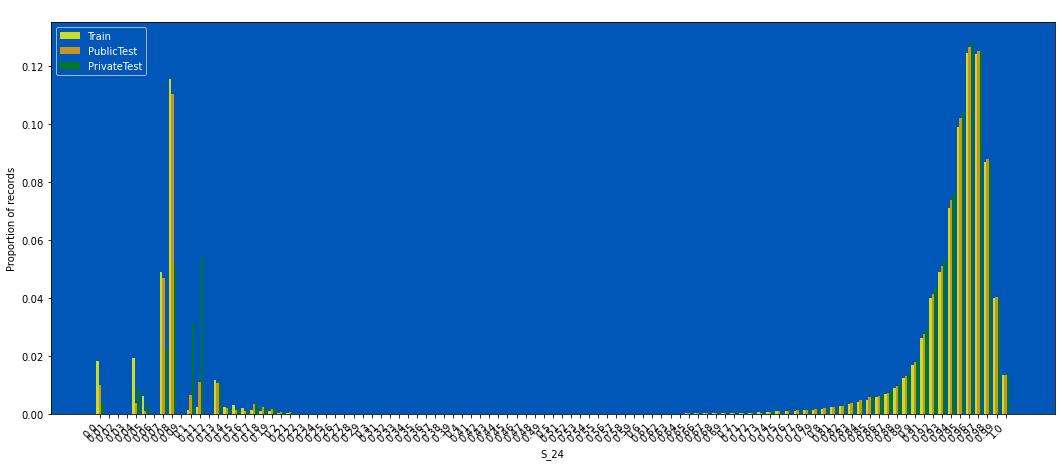

In [125]:
plot_train_test_distribution(df_list, "S_24", nunique_thr=650)

**Train Test Skew: Heavy**

### S_25

In [126]:
# plot_target_check(train, "S_25", q=50, use_raw_bin=True)

In [127]:
%%time
df_list = round_dfs(df_list, col="S_25", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 278 ms, sys: 1.04 s, total: 1.32 s
Wall time: 2.24 s


12847 null count, 0.002 null proportion
0.6575 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


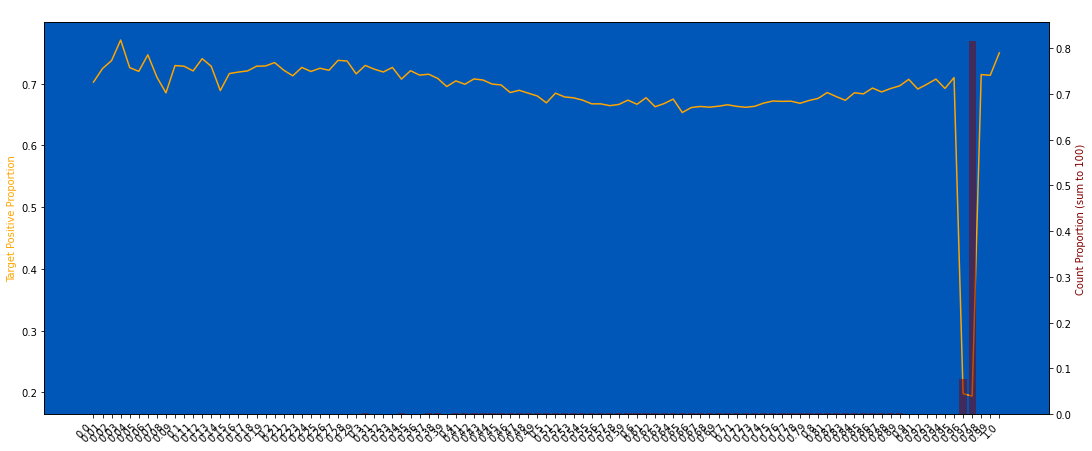

In [128]:
plot_target_check(train, "S_25", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


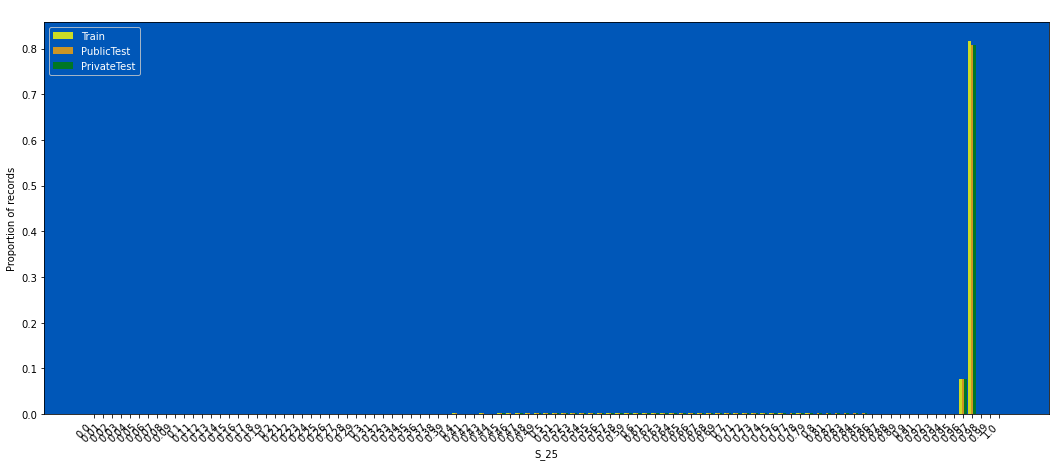

In [129]:
plot_train_test_distribution(df_list, "S_25", nunique_thr=1500)

**Train Test Skew: Moderate**

**ToDo:**
- Identify the subset of 0.97 & 0.98 to be replace by NaN

### S_26

634 null count, 0.000 null proportion
0.1325 of the targets have label = 1


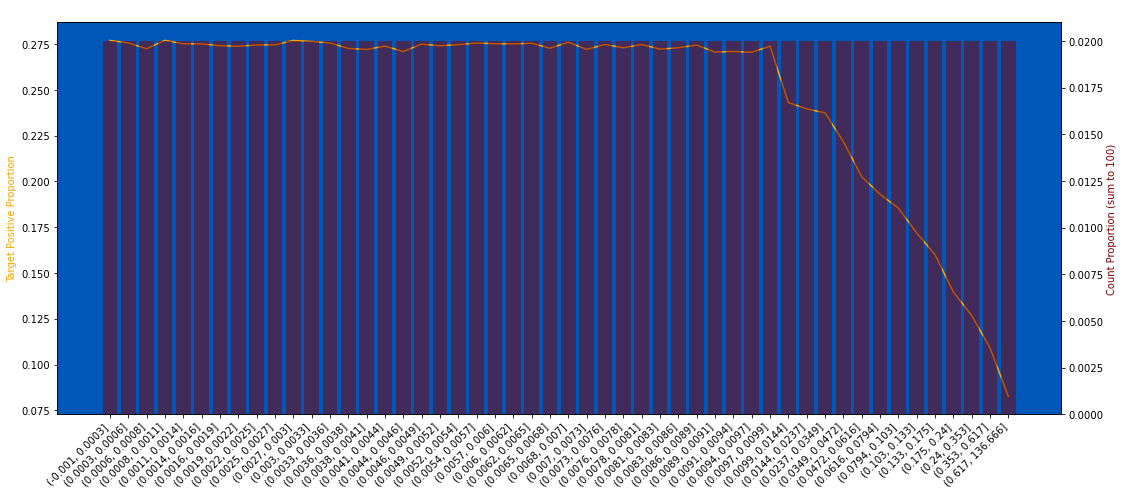

In [130]:
plot_target_check(train, "S_26", q=50, use_raw_bin=True)

In [131]:
%%time
df_list = round_dfs(df_list, col="S_26", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 285 ms, sys: 1.03 s, total: 1.32 s
Wall time: 2.25 s


634 null count, 0.000 null proportion
0.1325 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


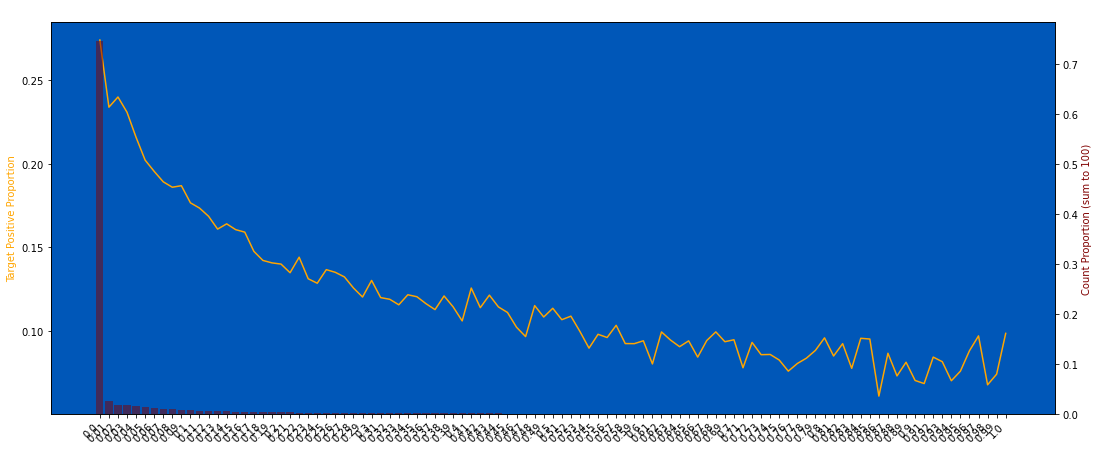

In [132]:
plot_target_check(train, "S_26", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


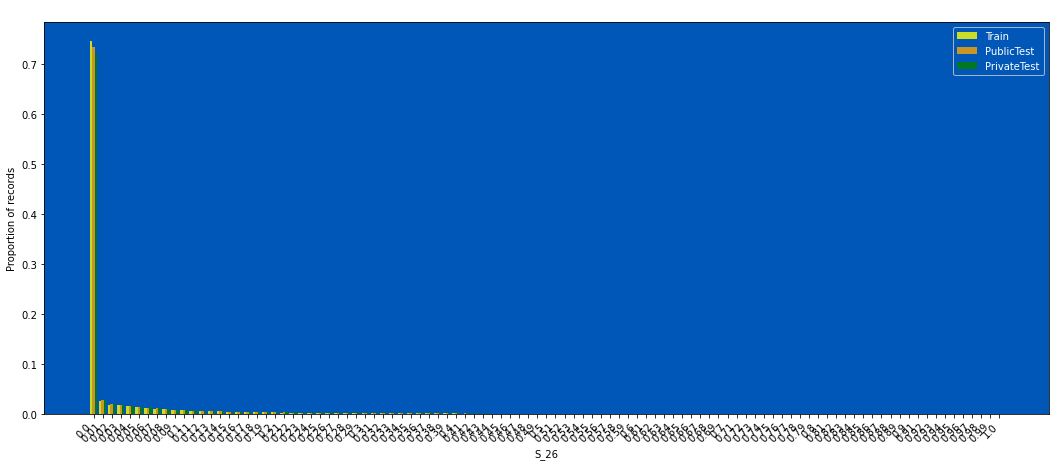

In [133]:
plot_train_test_distribution(df_list, "S_26", nunique_thr=2000)

### S_27

In [134]:
# plot_target_check(train, "S_27", q=50, use_raw_bin=True)

In [135]:
%%time
df_list = round_dfs(df_list, col="S_27", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 271 ms, sys: 1.07 s, total: 1.34 s
Wall time: 2.53 s


1400935 null count, 0.253 null proportion
0.1697 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


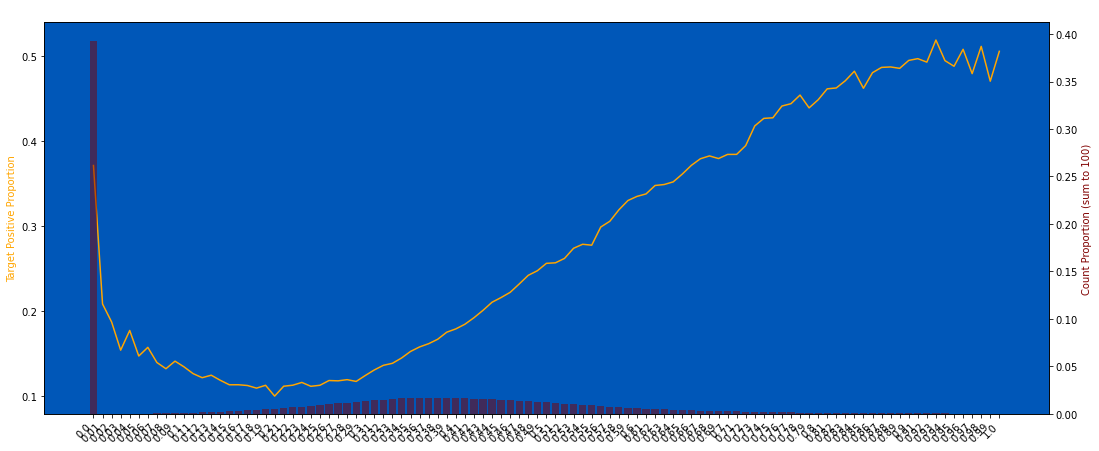

In [136]:
plot_target_check(train, "S_27", q=50, use_raw_bin=True, nunique_thr=1500, strfy_x=True)

**ToDo:**
- Impute, then set 0 & 0.01 as NaN??

Bottom 1% and Top 1% are dropped from this chart


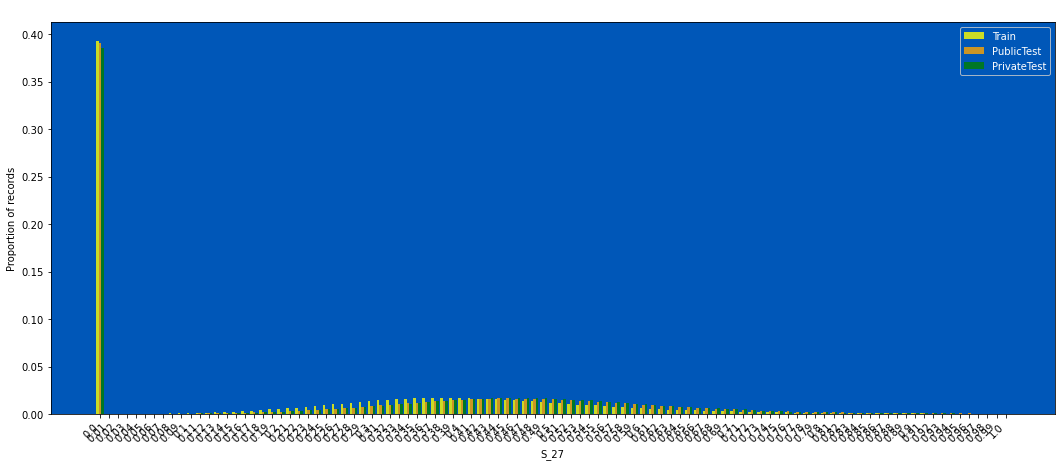

In [137]:
plot_train_test_distribution(df_list, "S_27", nunique_thr=1500)

**Train Test Skew: Heavy**

In [138]:
END = time.time()

In [139]:
print(f"{END - START:.2f} seconds elapsed")

114.94 seconds elapsed


### Column checking

In [141]:
from tqdm import tqdm

In [142]:
no_use_features = ["temp"] + df_list[0].columns[df_list[0].columns.str.endswith("_")].tolist()
no_use_features

['temp', 'S_11_', 'S_13_']

In [143]:
%%time
for df in tqdm(df_list):
    df.drop(columns=no_use_features, errors="ignore", inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]

CPU times: user 703 ms, sys: 1.09 s, total: 1.8 s
Wall time: 1.8 s


In [144]:
all_columns = get_cols(df_list[0], ("S_", "P_"))
print(all_columns)

['S_2', 'P_2', 'S_3', 'P_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9', 'S_11', 'S_12', 'S_13', 'S_15', 'P_4', 'S_16', 'S_17', 'S_18', 'S_19', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27']


In [145]:
d_col_nunique = df_list[0][all_columns].nunique()
less_unique_d_cols = d_col_nunique[d_col_nunique < 99].index.tolist()
for d in less_unique_d_cols:
    if df_list[0][d].dtype != np.int32:
        print(d, ":", df_list[0][d].dtype, "\n", sorted(df_list[0][d].unique().tolist()), "\n")

S_8 : float64 
 [0.1, 0.11, 0.12, 0.16, 0.17, 0.24, 0.25, 0.31, 0.32, 0.33, 0.35, 0.36, 0.4, 0.41, 0.45, 0.46, 0.47, 0.48, 0.49, 0.59, 0.6, 0.61, 0.66, 0.67, 0.7, 0.71, 0.74, 0.75, 0.76, 0.85, 0.86, 0.91, 0.92, 0.94, 1.0, nan, 0.93, 1.01, 1.02, 1.1, 1.11, 1.14, 1.15, 1.16, 1.22, 1.23] 

S_11 : float64 
 [-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, nan, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 77.0, 95.0] 

S_13 : float64 
 [5.0, nan, 1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0] 

S_15 : float64 
 [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, nan, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 

In [146]:
cols = list(
    set(less_unique_d_cols) - set(["S_8", "S_15", "P_4", "S_19"])
)

In [147]:
for col in tqdm(cols):
    for df in df_list:
        df[col] = integerize(df[col])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


In [148]:
%%time
train = df_list[0]
test = pd.concat(df_list[1:], axis=0)
test = test.sort_values(by=["customer_ID", "S_2"]).reset_index(drop=True)

CPU times: user 3.86 s, sys: 2.38 s, total: 6.24 s
Wall time: 7.31 s


In [149]:
train.shape, test.shape

((5531451, 27), (11363762, 26))

In [150]:
float64_columns = train.select_dtypes("float64").columns.tolist()
for col in float64_columns:
    temp = df_list[-1][col].astype(np.float32).values
    if (temp - df_list[-1][col]).abs().max() < 1e-4:
        print(f"{col} fulfill criteria to convert to float32")
        for df in df_list:
            df[col] = df[col].astype(np.float32)

P_2 fulfill criteria to convert to float32
S_3 fulfill criteria to convert to float32
P_3 fulfill criteria to convert to float32
S_5 fulfill criteria to convert to float32
S_7 fulfill criteria to convert to float32
S_8 fulfill criteria to convert to float32
S_9 fulfill criteria to convert to float32
S_12 fulfill criteria to convert to float32
S_15 fulfill criteria to convert to float32
P_4 fulfill criteria to convert to float32
S_16 fulfill criteria to convert to float32
S_17 fulfill criteria to convert to float32
S_19 fulfill criteria to convert to float32
S_22 fulfill criteria to convert to float32
S_23 fulfill criteria to convert to float32
S_24 fulfill criteria to convert to float32
S_25 fulfill criteria to convert to float32
S_26 fulfill criteria to convert to float32
S_27 fulfill criteria to convert to float32


In [152]:
sys.getsizeof(train) / 1e9, sys.getsizeof(test) / 1e9

(1.333079707, 3.420492506)

In [158]:
%%time
train.to_parquet(f"{INTERIM_DATA_PATH}/v2/train_parquet/train_spend_payment.parquet")
test.to_parquet(f"{INTERIM_DATA_PATH}/v2/test_parquet/test_spend_payment.parquet")

CPU times: user 8.42 s, sys: 561 ms, total: 8.98 s
Wall time: 8.31 s


In [159]:
test.shape

(11363762, 26)